# Object detection

Object detection is the computer vision task of detecting instances (such as humans, buildings, or cars) in an image. Object detection models receive an image as input and output
coordinates of the bounding boxes and associated labels of the detected objects. An image can contain multiple objects,
each with its own bounding box and a label (e.g. it can have a car and a building), and each object can
be present in different parts of an image (e.g. the image can have several cars).
This task is commonly used in autonomous driving for detecting things like pedestrians, road signs, and traffic lights.
Other applications include counting objects in images, image search, and more.

In this guide, you will learn how to:

 1. Finetune [DETR](https://huggingface.co/docs/transformers/model_doc/detr), a model that combines a convolutional
 backbone with an encoder-decoder Transformer, on the [Boat dataset](https://huggingface.co/datasets/SIS-2024-spring/Boat_dataset)
 dataset.
 2. Use your finetuned model for inference.

<Tip>
The task illustrated in this tutorial is supported by the following model architectures:

<!--This tip is automatically generated by `make fix-copies`, do not fill manually!-->

[Conditional DETR](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/conditional_detr), [Deformable DETR](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/deformable_detr), [DETA](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/deta), [DETR](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/detr), [Table Transformer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/table-transformer), [YOLOS](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/yolos)

<!--End of the generated tip-->

</Tip>

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install -q datasets transformers evaluate timm albumentations
```

You'll use 🤗 Datasets to load a dataset from the Hugging Face Hub, 🤗 Transformers to train your model,
and `albumentations` to augment the data. `timm` is currently required to load a convolutional backbone for the DETR model.

We encourage you to share your model with the community. Log in to your Hugging Face account to upload it to the Hub.
When prompted, enter your token to log in:

In [1]:
from huggingface_hub import notebook_login

notebook_login()

## Load the Boat dataset

The [Boat dataset](https://huggingface.co/datasets/SIS-2024-spring/Boat_dataset) contains images with
annotations identifying medical personal protective equipment (PPE) in the context of the COVID-19 pandemic.

Start by loading the dataset:

In [2]:
from datasets import Features, Value, Sequence

# Specify the correct schema for your dataset
features = Features({
    'image_id': Value('int32'),
    'image_path': Value('string'),
    'width': Value('int32'),
    'height': Value('int32'),
    'objects': {
        'id': Sequence(Value('int32')),
        'area': Sequence(Value('float32')), 
        'bbox': Sequence(Sequence(Value('float32'), length=4)), 
        'category': Sequence(Value('int32'))
    }
})

In [3]:
from datasets import load_dataset
dataset = load_dataset(
    'json', 
    data_files={'train': 'data/instances_train2024.jsonl', 
                'validation': 'data/instances_val2024.jsonl'},
    features=features
)
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image_path', 'width', 'height', 'objects'],
        num_rows: 3992
    })
    validation: Dataset({
        features: ['image_id', 'image_path', 'width', 'height', 'objects'],
        num_rows: 998
    })
})

You'll see that this dataset already comes with a training set containing 1000 images and a test set with 29 images.

To get familiar with the data, explore what the examples look like.

In [4]:
dataset["train"][0]

{'image_id': 1,
 'image_path': 'images/Lifebuoy_Scene3_blur1_2.png',
 'width': 640,
 'height': 480,
 'objects': {'id': [1],
  'area': [7140.0],
  'bbox': [[303.0, 248.0, 119.0, 60.0]],
  'category': [0]}}

The examples in the dataset have the following fields:
- `image_id`: the example image id
- `image`: a `PIL.Image.Image` object containing the image
- `width`: width of the image
- `height`: height of the image
- `objects`: a dictionary containing bounding box metadata for the objects in the image:
  - `id`: the annotation id
  - `area`: the area of the bounding box
  - `bbox`: the object's bounding box (in the [COCO format](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#coco) )
  - `category`: the object's category, with possible values including `Lifebuoy (0)`
You may notice that the `bbox` field follows the COCO format, which is the format that the DETR model expects.
However, the grouping of the fields inside `objects` differs from the annotation format DETR requires. You will
need to apply some preprocessing transformations before using this data for training.

To get an even better understanding of the data, visualize an example in the dataset.

In [5]:
def load_classes():
    class_list = []
    with open("data/classes.txt", "r") as f:
        class_list = [cname.strip() for cname in f.readlines()]
    return class_list

class_list = load_classes()

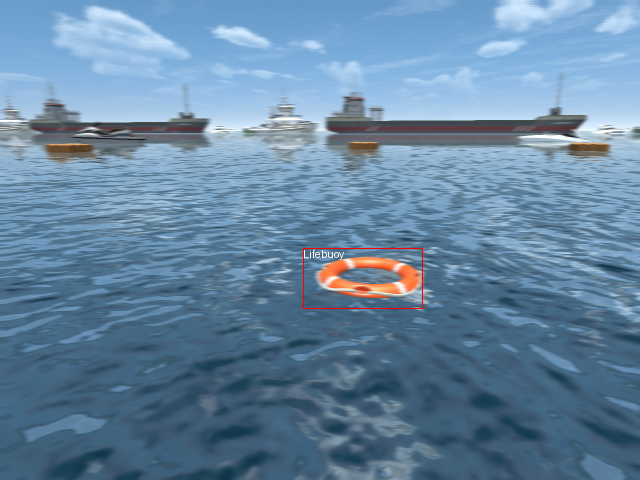

In [6]:
import numpy as np
import os
from PIL import Image, ImageDraw

image = Image.open(dataset["train"][0]["image_path"])
annotations = dataset["train"][0]["objects"]
draw = ImageDraw.Draw(image)

# categories = dataset["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(class_list, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

To visualize the bounding boxes with associated labels, you can get the labels from the dataset's metadata, specifically
the `category` field.
You'll also want to create dictionaries that map a label id to a label class (`id2label`) and the other way around (`label2id`).
You can use them later when setting up the model. Including these maps will make your model reusable by others if you share
it on the Hugging Face Hub.

As a final step of getting familiar with the data, explore it for potential issues. One common problem with datasets for
object detection is bounding boxes that "stretch" beyond the edge of the image. Such "runaway" bounding boxes can raise
errors during training and should be addressed at this stage. There are a few examples with this issue in this dataset.
To keep things simple in this guide, we remove these images from the data.

## Preprocess the data

To finetune a model, you must preprocess the data you plan to use to match precisely the approach used for the pre-trained model.
[AutoImageProcessor](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoImageProcessor) takes care of processing image data to create `pixel_values`, `pixel_mask`, and
`labels` that a DETR model can train with. The image processor has some attributes that you won't have to worry about:

- `image_mean = [0.485, 0.456, 0.406 ]`
- `image_std = [0.229, 0.224, 0.225]`

These are the mean and standard deviation used to normalize images during the model pre-training. These values are crucial
to replicate when doing inference or finetuning a pre-trained image model.

Instantiate the image processor from the same checkpoint as the model you want to finetune.

In [7]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Before passing the images to the `image_processor`, apply two preprocessing transformations to the dataset:
- Augmenting images
- Reformatting annotations to meet DETR expectations

First, to make sure the model does not overfit on the training data, you can apply image augmentation with any data augmentation library. Here we use [Albumentations](https://albumentations.ai/docs/) ...
This library ensures that transformations affect the image and update the bounding boxes accordingly.
The 🤗 Datasets library documentation has a detailed [guide on how to augment images for object detection](https://huggingface.co/docs/datasets/object_detection),
and it uses the exact same dataset as an example. Apply the same approach here, resize each image to (480, 480),
flip it horizontally, and brighten it:

In [8]:
import albumentations
import numpy as np
import torch

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        # albumentations.HorizontalFlip(p=1.0),
        albumentations.HorizontalFlip(p=0.5),
        # albumentations.RandomBrightnessContrast(p=1.0),
        albumentations.RandomBrightnessContrast(p=0.5),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

/usr/local/lib/python3.8/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


The `image_processor` expects the annotations to be in the following format: `{'image_id': int, 'annotations': List[Dict]}`,
 where each dictionary is a COCO object annotation. Let's add a function to reformat annotations for a single example:

In [9]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

Now you can combine the image and annotation transformations to use on a batch of examples:

In [10]:
# Create an empty placeholder image
def create_empty_image(width=640, height=480, color=(0, 0, 0)):
    return np.zeros((height, width, 3), dtype=np.uint8)  # Black image by default

In [11]:
from PIL import Image
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image_path, objects in zip(examples["image_path"], examples["objects"]):
        if not os.path.exists(image_path):
            print(f'{image_path} does not exist, using a placeholder image.')
            # Use a black placeholder image if the actual image is missing
            image = create_empty_image()
        else:
            image = Image.open(image_path)
            image = np.array(image.convert("RGB"))[:, :, ::-1]
        
        pass_bbox = False
        for bbox in objects["bbox"]:
            x_min, y_min, w, h = bbox
            if x_min < 0 or y_min < 0 or w <= 0 or h <= 0 or w >= 1 or h >= 1:
                pass_bbox = True
        
        if pass_bbox:
            area.append(objects["area"])
            images.append(image)
            bboxes.append(objects["bbox"])
            categories.append(objects["category"])

        else:
            out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])
    
            area.append(objects["area"])
            images.append(out["image"])
            bboxes.append(out["bboxes"])
            categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

Apply this preprocessing function to the entire dataset using 🤗 Datasets [with_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.with_transform) method. This method applies
transformations on the fly when you load an element of the dataset.

At this point, you can check what an example from the dataset looks like after the transformations. You should see a tensor
with `pixel_values`, a tensor with `pixel_mask`, and `labels`.

In [12]:
dataset["train"] = dataset["train"].with_transform(transform_aug_ann)
dataset["train"][15]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'pixel_values': tensor([[[ 1.4269,  1.4269,  1.4269,  ...,  1.3755,  1.3755,  1.3755],
          [ 1.4269,  1.4269,  1.4269,  ...,  1.3755,  1.3755,  1.3755],
          [ 1.4269,  1.4269,  1.4269,  ...,  1.3755,  1.3755,  1.3755],
          ...,
          [-0.1999, -0.1999, -0.1999,  ..., -0.0287, -0.0287, -0.0287],
          [-0.2171, -0.2171, -0.2171,  ..., -0.0458, -0.0287, -0.0287],
          [-0.2342, -0.2342, -0.2342,  ..., -0.0458, -0.0287, -0.0287]],
 
         [[ 0.7829,  0.7829,  0.7829,  ...,  0.7304,  0.7304,  0.7304],
          [ 0.7829,  0.7829,  0.7829,  ...,  0.7304,  0.7304,  0.7304],
          [ 0.7829,  0.7829,  0.7829,  ...,  0.7129,  0.7129,  0.7129],
          ...,
          [-0.5301, -0.5301, -0.5301,  ..., -0.3375, -0.3200, -0.3200],
          [-0.5476, -0.5476, -0.5476,  ..., -0.3550, -0.3375, -0.3375],
          [-0.5651, -0.5651, -0.5651,  ..., -0.3550, -0.3375, -0.3375]],
 
         [[ 0.1128,  0.1128,  0.1128,  ...,  0.0779,  0.0779,  0.0779],
          [ 

You have successfully augmented the individual images and prepared their annotations. However, preprocessing isn't
complete yet. In the final step, create a custom `collate_fn` to batch images together.
Pad images (which are now `pixel_values`) to the largest image in a batch, and create a corresponding `pixel_mask`
to indicate which pixels are real (1) and which are padding (0).

In [13]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    # encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## Training the DETR model

You have done most of the heavy lifting in the previous sections, so now you are ready to train your model!
The images in this dataset are still quite large, even after resizing. This means that finetuning this model will
require at least one GPU.

Training involves the following steps:
1. Load the model with [AutoModelForObjectDetection](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForObjectDetection) using the same checkpoint as in the preprocessing.
2. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).
3. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, image processor, and data collator.
4. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

When loading the model from the same checkpoint that you used for the preprocessing, remember to pass the `label2id`
and `id2label` maps that you created earlier from the dataset's metadata. Additionally, we specify `ignore_mismatched_sizes=True` to replace the existing classification head with a new one.

In [14]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In the [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments) use `output_dir` to specify where to save your model, then configure hyperparameters as you see fit.
It is important you do not remove unused columns because this will drop the image column. Without the image column, you
can't create `pixel_values`. For this reason, set `remove_unused_columns` to `False`.
If you wish to share your model by pushing to the Hub, set `push_to_hub` to `True` (you must be signed in to Hugging
Face to upload your model).

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50-finetuned-100-epochs-lifebuoy-dataset",
    per_device_train_batch_size=8,
    num_train_epochs=100,
    fp16=False,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    hub_model_id="ARG-NCTU/detr-resnet-50-finetuned-100-epochs-lifebuoy-dataset",
)

Finally, bring everything together, and call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train):

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"],
    tokenizer=image_processor,
)

trainer.train()

Step,Training Loss
50,2.239400
100,1.922300
150,1.192400
200,0.931100
250,0.843800
300,0.752100
350,0.726000
400,0.717200
450,0.671300
500,0.731600


If you have set `push_to_hub` to `True` in the `training_args`, the training checkpoints are pushed to the
Hugging Face Hub. Upon training completion, push the final model to the Hub as well by calling the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method.

In [ ]:
trainer.push_to_hub(commit_message='detr-resnet-50-finetuned-lifebuoy-dataset 100 epoch')

## Evaluate

Object detection models are commonly evaluated with a set of <a href="https://cocodataset.org/#detection-eval">COCO-style metrics</a>.
You can use one of the existing metrics implementations, but here you'll use the one from `torchvision` to evaluate the final
model that you pushed to the Hub.

To use the `torchvision` evaluator, you'll need to prepare a ground truth COCO dataset. The API to build a COCO dataset
requires the data to be stored in a certain format, so you'll need to save images and annotations to disk first. Just like
when you prepared your data for training, the annotations from the `cppe5["test"]` need to be formatted. However, images
should stay as they are.

The evaluation step requires a bit of work, but it can be split in three major steps.
First, prepare the `cppe5["test"]` set: format the annotations and save the data to disk.

In [ ]:
import json
from PIL import Image

# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_annotation_file_images(dataset, mode="val"):
    output_json = {}
    path_output = f"{os.getcwd()}/output/"

    if not os.path.exists(path_output):
        os.makedirs(path_output)

    if mode == "val":
        path_anno = os.path.join(path_output, "lifebuoy_ann_val.json")
    else:
        path_anno = os.path.join(path_output, "lifebuoy_ann_val_real.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    for example in dataset:
        ann = val_formatted_anns(example["image_id"], example["objects"])
        if not os.path.exists(example["image_path"]):
            continue
        image_example = Image.open(example["image_path"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": image_example.width,
                "height": image_example.height,
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for image_path, img_id in zip(dataset["image_path"], dataset["image_id"]):
        if not os.path.exists(image_path):
            continue
        im = Image.open(image_path)
        path_img = os.path.join(path_output, f"{img_id}.png")
        im.save(path_img)

    return path_output, path_anno

Next, prepare an instance of a `CocoDetection` class that can be used with `cocoevaluator`.

In [ ]:
!pip3 install pycocotools

In [ ]:
import torchvision


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}

Finally, load the metrics and run the evaluation.

In [ ]:
from transformers import AutoModelForObjectDetection, AutoImageProcessor
import evaluate
from tqdm import tqdm
import torch

def eval(eval_dataset, mode="val"):
    im_processor = AutoImageProcessor.from_pretrained("ARG-NCTU/detr-resnet-50-finetuned-100-epochs-lifebuoy-dataset")
    path_output, path_anno = save_annotation_file_images(eval_dataset, mode)
    test_ds_coco_format = CocoDetection(path_output, im_processor, path_anno)
    
    model = AutoModelForObjectDetection.from_pretrained("ARG-NCTU/detr-resnet-50-finetuned-100-epochs-lifebuoy-dataset")
    module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
    val_dataloader = torch.utils.data.DataLoader(
        test_ds_coco_format, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn
    )
    
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(val_dataloader)):
            pixel_values = batch["pixel_values"]
            pixel_mask = batch["pixel_mask"]
    
            labels = [
                {k: v for k, v in t.items()} for t in batch["labels"]
            ]  # these are in DETR format, resized + normalized
    
            # forward pass
            outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
    
            orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
            results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api
    
            module.add(prediction=results, reference=labels)
            del batch
    
    results = module.compute()
    print(results)

In [ ]:
eval(dataset["validation"], mode="val")

These results can be further improved by adjusting the hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). Give it a go!

## Inference

Now that you have finetuned a DETR model, evaluated it, and uploaded it to the Hugging Face Hub, you can use it for inference.
The simplest way to try out your finetuned model for inference is to use it in a [Pipeline](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.Pipeline). Instantiate a pipeline
for object detection with your model, and pass an image to it:

In [ ]:
from transformers import pipeline
import requests

# url = "https://i.imgur.com/2lnWoly.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

image = Image.open(dataset["validation"][0]["image_path"])

obj_detector = pipeline("object-detection", model="ARG-NCTU/detr-resnet-50-finetuned-100-epochs-lifebuoy-dataset")
obj_detector(image)

You can also manually replicate the results of the pipeline if you'd like:

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("ARG-NCTU/detr-resnet-50-finetuned-lifebuoy-dataset")
model = AutoModelForObjectDetection.from_pretrained("ARG-NCTU/detr-resnet-50-finetuned-lifebuoy-dataset")

with torch.no_grad():
    inputs = image_processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Let's plot the result:

In [ ]:
draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, x2, y2 = tuple(box)
    draw.rectangle((x, y, x2, y2), outline="red", width=1)
    draw.text((x, y), model.config.id2label[label.item()], fill="white")

image

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import pipeline, AutoImageProcessor, AutoModelForObjectDetection
from torchvision.ops import box_iou

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the object detector model and move to GPU
obj_detector = pipeline("object-detection", model="ARG-NCTU/detr-resnet-50-finetuned-100-epochs-lifebuoy-dataset", device=device)
image_processor = AutoImageProcessor.from_pretrained("ARG-NCTU/detr-resnet-50-finetuned-100-epochs-lifebuoy-dataset")
model = AutoModelForObjectDetection.from_pretrained("ARG-NCTU/detr-resnet-50-finetuned-100-epochs-lifebuoy-dataset").to(device)

# Initialize confusion matrix counts
TP = FP = TN = FN = 0

# Loop through the validation dataset to calculate confusion matrix for each image
for i in range(len(dataset["validation"])):
    if not os.path.exists(dataset["validation"][i]["image_path"]):
        continue
    # Load the image
    image = Image.open(dataset["validation"][i]["image_path"])

    # Perform inference
    with torch.no_grad():
        inputs = image_processor(images=image, return_tensors="pt").to(device)  # Move inputs to GPU
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]]).to(device)  # Move target sizes to GPU
        results = image_processor.post_process_object_detection(outputs, threshold=0.5, target_sizes=target_sizes)[0]

    # Ground truth bounding boxes in [x1, y1, w, h] format
    gt_boxes = dataset["validation"][i]["objects"]["bbox"]  # True bounding boxes for the current image
    
    # Convert ground truth boxes from [x1, y1, w, h] to [x1, y1, x2, y2]
    ground_truth_boxes = []
    for box in gt_boxes:
        x1, y1, w, h = box
        x2 = x1 + w
        y2 = y1 + h
        ground_truth_boxes.append([x1, y1, x2, y2])
    
    ground_truth_boxes = torch.tensor(ground_truth_boxes).to(device)  # Convert to tensor and move to GPU
    
    # Ground truth labels: 0 = lifebuoy, other categories = background
    ground_truth_labels = torch.tensor([category for category in dataset["validation"][i]["objects"]["category"]]).to(device)

    # Convert predicted boxes to tensor and move to GPU
    pred_boxes = torch.tensor([box.tolist() for box in results['boxes']]).to(device)
    
    # Calculate IoU between predicted and ground truth boxes
    if len(pred_boxes) > 0 and len(ground_truth_boxes) > 0:
        iou_matrix = box_iou(pred_boxes, ground_truth_boxes)

        # Iterate over each detection and compare with ground truth
        for j, (score, label, box) in enumerate(zip(results["scores"], results["labels"], results["boxes"])):
            max_iou, gt_idx = torch.max(iou_matrix[j], dim=0)
            # print(max_iou)
            if max_iou > 0.5:  # IoU threshold
                if label == ground_truth_labels[gt_idx]:  # Correct label (True Positive)
                    TP += 1
                else:  # Incorrect label (False Positive)
                    FP += 1
            else:
                FN += 1  # Lifebuoy not detected correctly (False Negative)
    
    # If there are no predicted bounding boxes, count all as False Negatives
    if len(pred_boxes) == 0 and len(ground_truth_boxes) > 0:
        FN += len(ground_truth_boxes)

# Calculate TN (True Negative)
TN = 0  # Assuming all images without lifebuoys are true negatives

# Create confusion matrix
confusion_matrix = [[TP, FP], [FN, TN]]

# Plot the confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = [0, 1]
plt.xticks(tick_marks, ['Lifebuoy', 'Background'])
plt.yticks(tick_marks, ['Pred Lifebuoy', 'Pred Background'])

# Annotate the confusion matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i][j], horizontalalignment='center', color='black')

plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.savefig('confusion_mat.png')
plt.show()

